In [1]:
import os 

os.chdir('app/')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path_to_data = 'data'

In [4]:
train = pd.read_csv(path_to_data + '/train.csv', usecols=['client_id', 'gender'])
mcc_codes = pd.read_csv(path_to_data + '/mcc_codes.csv', sep=';')
test_sample_submission = pd.read_csv(path_to_data + '/test_sample_submission.csv', usecols=['client_id', 'probability'])
test = pd.read_csv(path_to_data + '/test.csv', usecols=['client_id'])
trans_types = pd.read_csv(path_to_data + '/trans_types.csv', sep=';')
transactions = pd.read_csv(path_to_data + '/transactions.csv')

In [5]:
print('Size of datasets:\n')
print('train', train.shape)
print('mcc_codes', mcc_codes.shape)
print('trans_types', trans_types.shape)
print('test', test.shape)
print('transactions', transactions.shape)

Size of datasets:

train (7560, 2)
mcc_codes (184, 2)
trans_types (155, 2)
test (840, 1)
transactions (3563529, 7)


In [6]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg


In [80]:
print('duplicated values of transactions:', transactions.duplicated().sum())
print('-'*20)
print('null values of transactions:\n', transactions.isnull().sum())
print('-'*20)
print('null values of mcc codes:\n', mcc_codes.isnull().sum())
print('-'*20)
print('null values of transactions types:\n', trans_types.isnull().sum())

duplicated values of transactions: 4
--------------------
null values of transactions:
 client_id           0
trans_time          0
mcc_code            0
trans_type          0
amount              0
term_id       1443778
trans_city          0
amount_log          0
income        2927703
spent          635826
dtype: int64
--------------------
null values of mcc codes:
 mcc_code           0
mcc_description    0
dtype: int64
--------------------
null values of transactions types:
 trans_type           0
trans_description    0
dtype: int64


In [8]:
print('Number of unique:')
print(transactions['client_id'].nunique())

# top 10 clients who most often used the services of the bank
transactions['client_id'].value_counts()[:10]

Number of unique:
8400


fbf94bb37e250669ea74b20ddaa89e0e    84313
e91858185ae43cf3970220748893a01b    14404
210a288dba0bd3bf6ce90f1f1b188951    13876
7364b8067c0c257b45efd73c3d0a4028    11699
07e279042b1da23710fa2f65034d30b9    11447
e43f6f0ead88c8a17fc0543aa3e1599a    11442
aba68a1204a662908cebfc09a1d5bbd3    10520
f74c1398ead286f297e003b5e810ee99     9356
8d69e4ecae4b509d528b9a0168f749d0     7998
c20371cb1683ff049f277439b4aafb28     7660
Name: client_id, dtype: int64

Text(0.5, 1.0, 'Top-20 MCC')

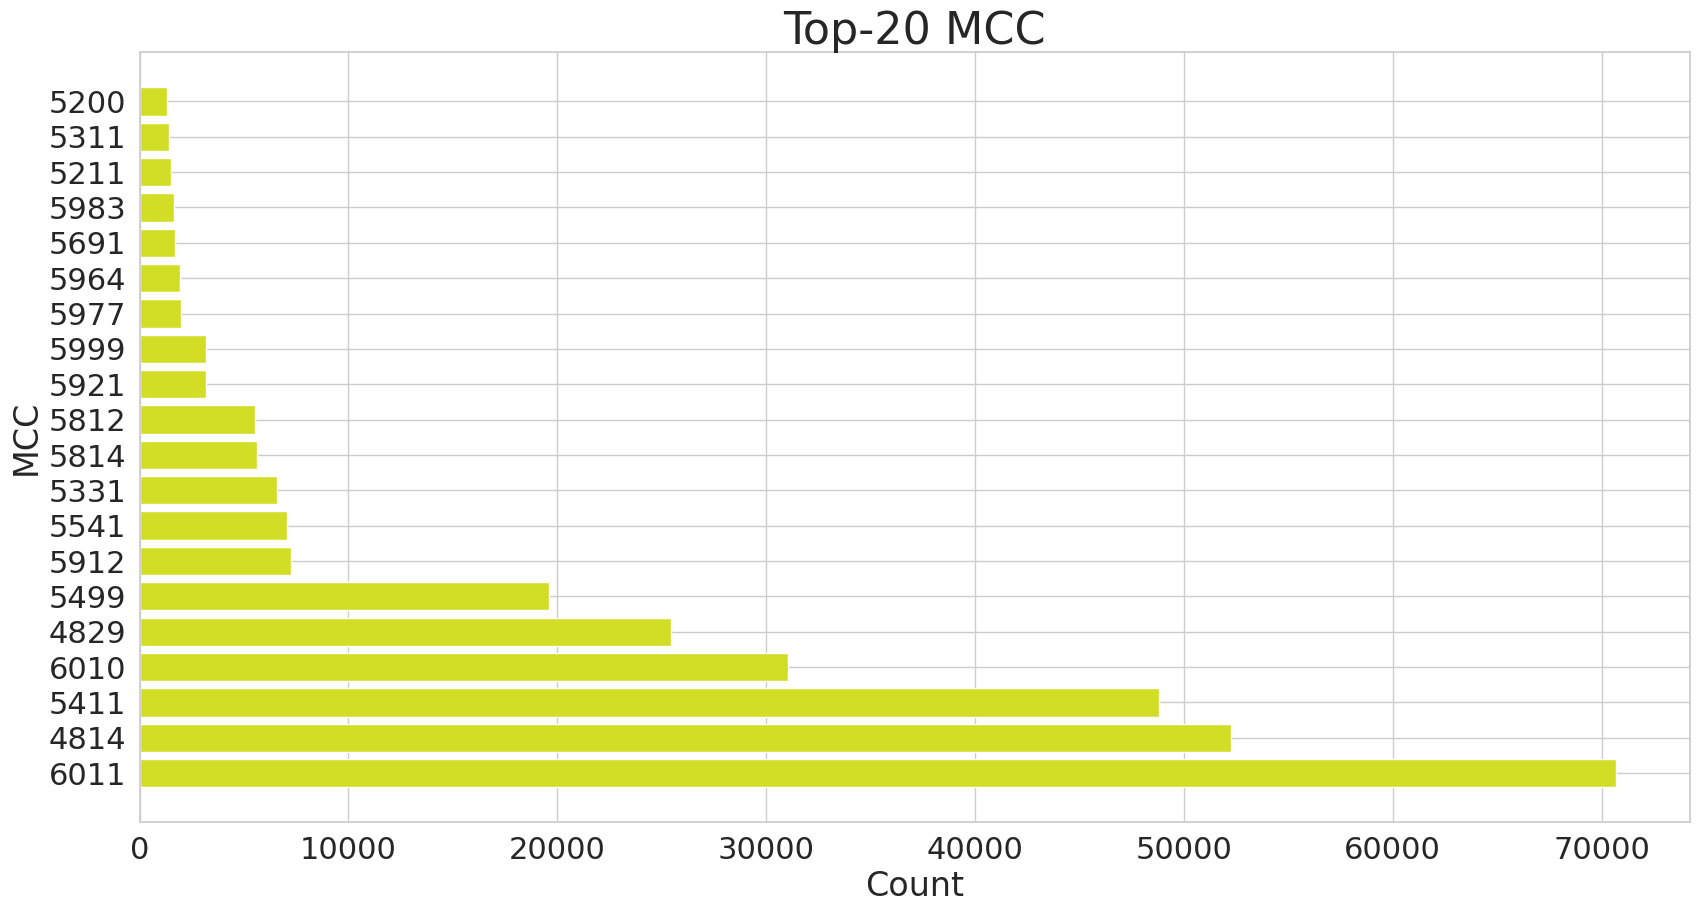

In [73]:
fig, ax = plt.subplots(figsize=(20, 10))

mcc_counts = df['mcc_code'].value_counts(ascending=False).iloc[:20]

ax.barh(mcc_counts.index.astype('str'), mcc_counts, color='#D2DE26')
ax.set_xlabel('Count', fontsize=24)
ax.set_ylabel('MCC', fontsize=24)
ax.set_title('Top-20 MCC', fontsize=32)

In [9]:
def preproc(x):
  if x > 0:
    return np.log(1 + x)
  return -np.log(1 - x)

In [10]:
transactions['amount_log'] = transactions['amount'].apply(preproc)

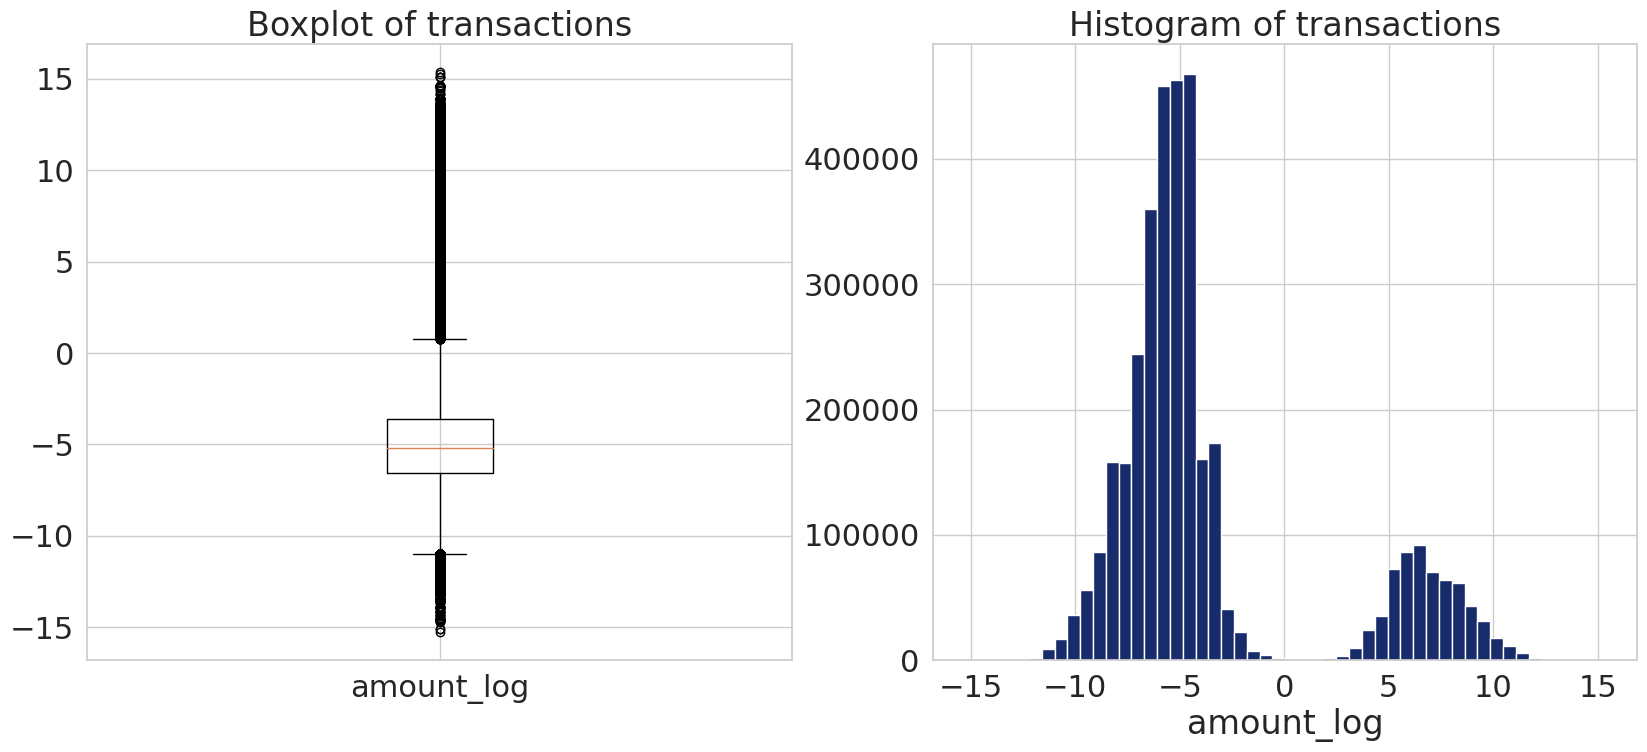

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Boxplot of transactions')
labels = ['amount_log']
axes[0].boxplot(transactions['amount_log'], labels=labels)

axes[1].set_title('Histogram of transactions')

axes[1].hist(transactions['amount_log'], bins=50, label = 'amount_log', color = '#182c6bff')
axes[1].set_xlabel('amount_log')

plt.show()

In [12]:
def remove_outlier_IQR(df):
    # IQR
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    # removing the outliers
    df_without_outliers=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    # return data without outliers
    return df_without_outliers

data_with_no_outliers=remove_outlier_IQR(transactions['amount_log'])

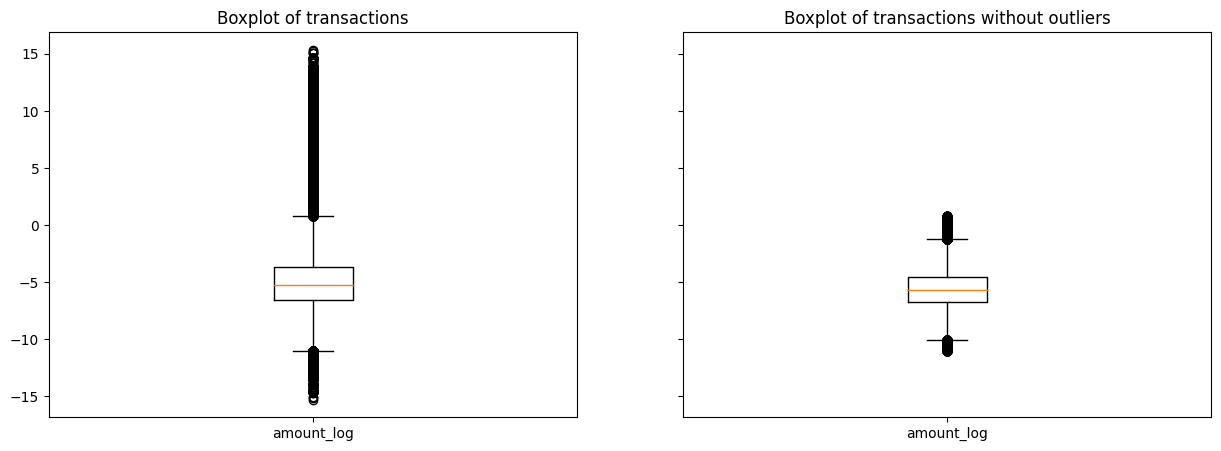

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

axes[0].set_title('Boxplot of transactions')

labels = ['amount_log']
axes[0].boxplot(transactions['amount_log'], labels=labels)
axes[1].set_title('Boxplot of transactions without outliers')
axes[1].boxplot(data_with_no_outliers, labels=labels)

plt.show()

<Axes: xlabel='mcc_description'>

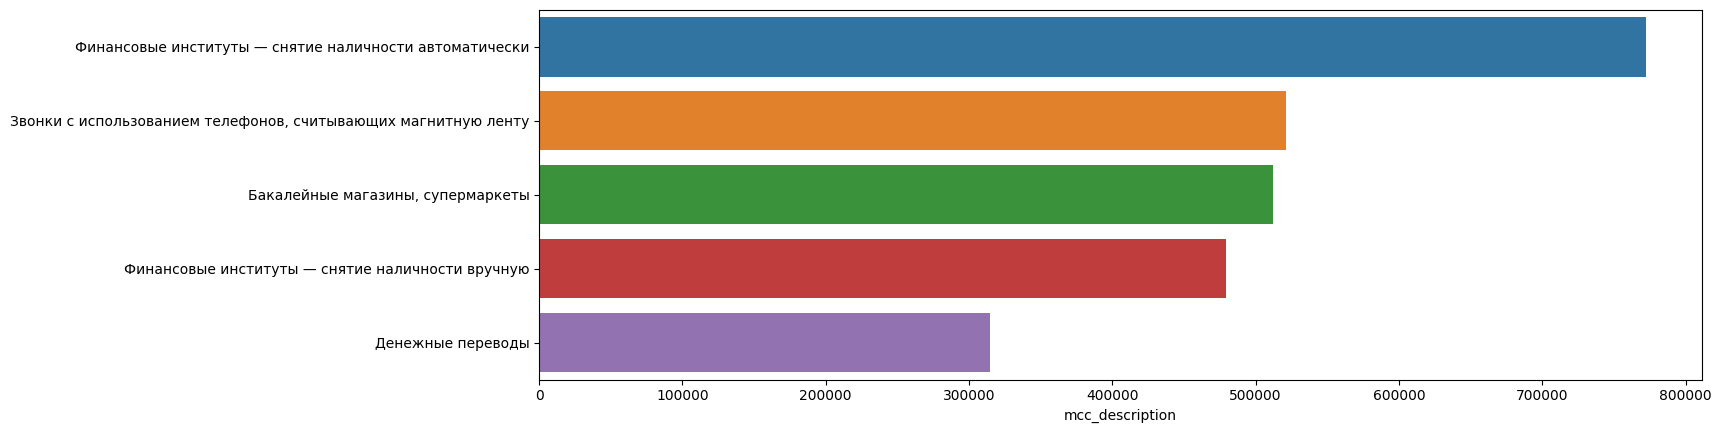

In [14]:
# services most often used by bank customers

fig, axs = plt.subplots(ncols=1)
fig.set_figwidth(15)

data0 = transactions.merge(mcc_codes, on='mcc_code')
data = data0.merge(trans_types, on='trans_type')

# top 5 of transaction codes
sns.barplot(x=data['mcc_description'].value_counts()[:5],y=data['mcc_description'].value_counts()[:5].index)

<Axes: xlabel='trans_description'>

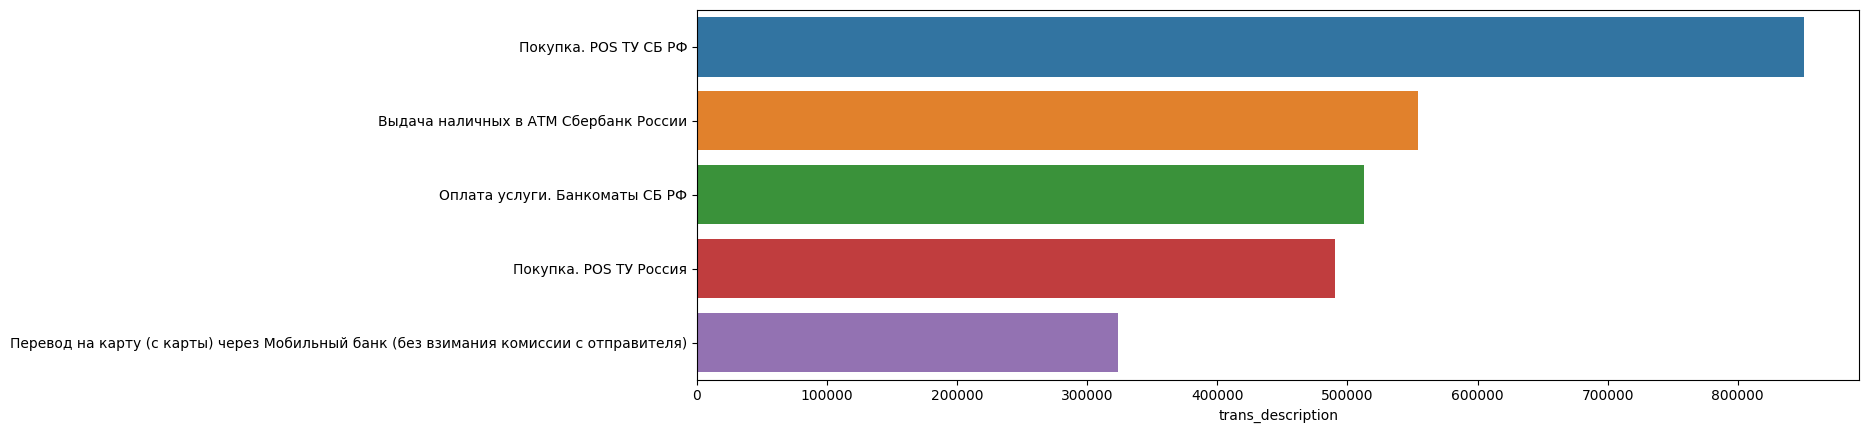

In [15]:
fig, axs = plt.subplots(ncols=1)
fig.set_figwidth(15)

# top 5 of transaction types
sns.barplot(x=data['trans_description'].value_counts()[:5],y=data['trans_description'].value_counts()[:5].index)

In [16]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city,amount_log
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,-7.500839
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,8.981620
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,-9.416912
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,3.922369
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,3.834926


In [17]:
transactions.loc[transactions['amount'] > 0, 'income'] = transactions['amount']
transactions.loc[transactions['amount'] <= 0, 'spent'] = transactions['amount']

In [18]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,-7.500839,NaN,-1808.56
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,8.981620,7954.51,NaN
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,-9.416912,NaN,-12293.56
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,3.922369,49.52,NaN
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,3.834926,45.29,NaN


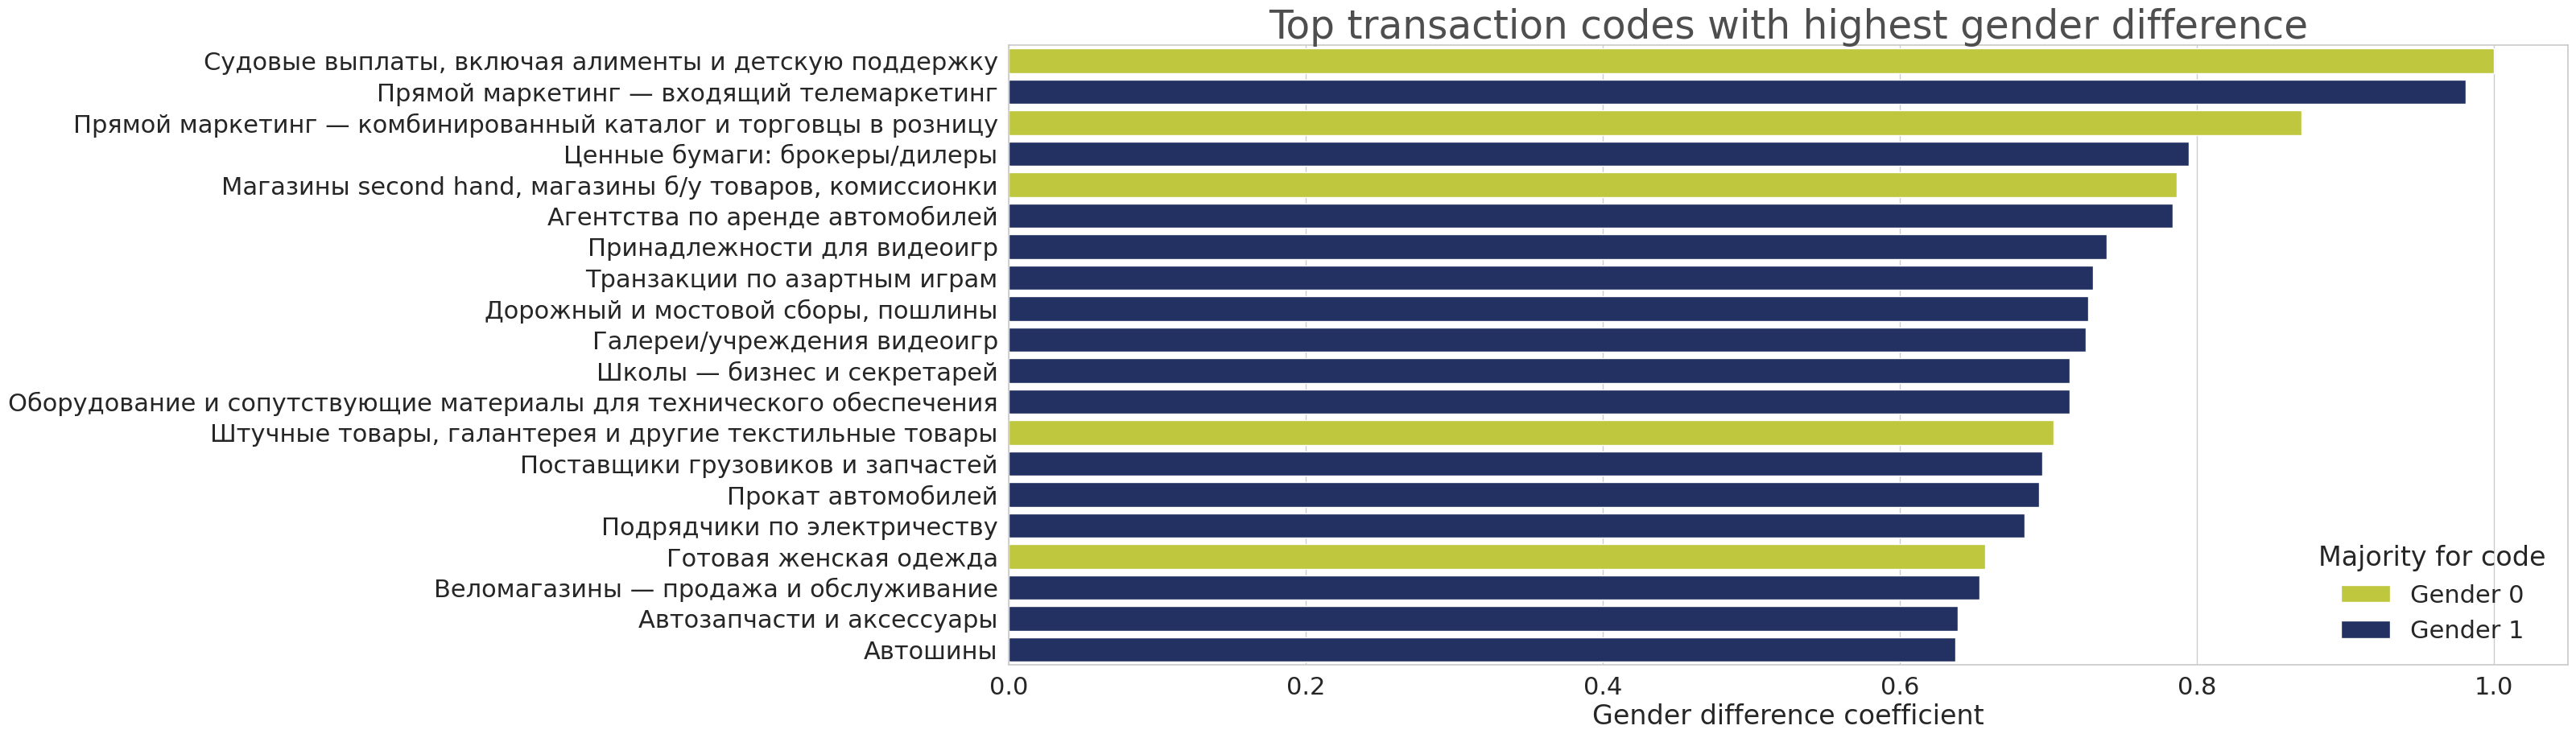

In [19]:
# counting the number of transactions made per gender by code type

train_gender = mcc_codes.copy(deep=True)
train_gender['majority'] = 0

data_train = pd.merge(transactions, train, on='client_id', how="right")

def calc_count_0(row):
    return len((data_train[(data_train['mcc_code'] == row['mcc_code']) & (data_train['gender'] == 0)]))

def calc_count_1(row):
    return len((data_train[(data_train['mcc_code'] == row['mcc_code']) & (data_train['gender'] == 1)]))

train_gender['0'] = train_gender.apply(lambda row: calc_count_0(row), axis=1)
train_gender['1'] = train_gender.apply(lambda row: calc_count_1(row), axis=1)

train_gender['coef'] = abs(train_gender['0'] - train_gender['1'])/(train_gender['0'] + train_gender['1'])

train_gender['majority'] = train_gender['1'] > train_gender['0']

plt.figure(figsize=(25,10))
sns.set(font_scale=2,style='whitegrid')

ax = sns.barplot(x="coef", y="mcc_description", data=train_gender.sort_values(by=['coef'], ascending=False).head(20),
            hue='majority', palette={True:'#182c6bff', False:'#d2de26ff'}, dodge=False)
plt.title('Top transaction codes with highest gender difference', size = 35, color='#4f4e4e')
plt.xlabel('Gender difference coefficient')
plt.ylabel('')

labels = ['Gender 0', 'Gender 1']
h, l = ax.get_legend_handles_labels()

ax.legend(h, labels, title="Majority for code", framealpha=0.0, loc="lower right")

In [20]:
gender_diff_mcc = list(train_gender.sort_values('coef', ascending=False).iloc[:20]['mcc_code'])

In [21]:
# from this table we can see that mcc with high gender difference are quite rare

mcc_counts = transactions['mcc_code'].value_counts().reset_index()
mcc_counts.columns = ['mcc_code', 'count']

mcc_counts[mcc_counts['mcc_code'].isin(gender_diff_mcc)]

,mcc_code,count
19,7995,12744
23,5533,11185
39,7994,5233
44,5621,4287
81,4784,841
85,6211,750
99,7993,468
102,5532,338
107,5931,289
113,5013,240


In [22]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,-7.500839,NaN,-1808.56
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,8.981620,7954.51,NaN
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,-9.416912,NaN,-12293.56
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,3.922369,49.52,NaN
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,3.834926,45.29,NaN


In [23]:
trans_train = pd.merge(transactions, train, on='client_id')
trans_test = pd.merge(transactions, test, on='client_id')

In [24]:
base_date = pd.to_datetime('2022-01-01')

for df in [trans_train, trans_test]:
    df['trans_time'] = df['trans_time'].astype(str)
    df[['days', 'time']] = df['trans_time'].str.split(' ', expand=True)
    df['days'] = pd.to_timedelta(df['days'].astype(int), unit='D')
    df['time'] = pd.to_timedelta(df['time'])
    df['event_time'] = base_date + df['days'] + df['time']
    df.drop(['trans_time', 'days', 'time'], axis=1, inplace=True)

In [25]:
trans_train.head()

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,4829,2370,-1808.56,NaN,Tver,-7.500839,NaN,-1808.56,0,2022-02-05 08:24:41
1,d1bbbc9a0e0410d3cf12a3d2f44f3450,4829,2370,-3390.41,NaN,Tver,-8.129001,NaN,-3390.41,0,2022-04-16 12:57:32
2,d1bbbc9a0e0410d3cf12a3d2f44f3450,4814,1030,-144.50,889003,Tver,-4.980176,NaN,-144.50,0,2023-04-01 19:32:01
3,d1bbbc9a0e0410d3cf12a3d2f44f3450,6011,2010,-3542.30,NaN,Tver,-8.172814,NaN,-3542.30,0,2022-03-25 09:22:26
4,d1bbbc9a0e0410d3cf12a3d2f44f3450,6011,2010,-3542.70,NaN,Tver,-8.172927,NaN,-3542.70,0,2022-03-16 13:31:57


In [26]:
# to get hour and minute
trans_train['hour'] = trans_train['event_time'].dt.strftime('%H')

In [27]:
trans_train.tail()

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time,hour
3238727,b6714c0ca16193cbd419623eb70b1488,4814,1030,-73.31,941133,Khabarovsk,-4.308246,NaN,-73.31,1,2023-03-22 16:57:21,16
3238728,ee4c5d78cbb27771979714ffa903ef5d,6011,7010,72.71,483632,Moscow,4.300138,72.71,NaN,0,2022-11-10 15:12:47,15
3238729,d428ad799c5790b036beb67cc1b81075,6011,2010,-14463.42,10172441,Khabarovsk,-9.579447,NaN,-14463.42,0,2023-03-22 16:37:17,16
3238730,d428ad799c5790b036beb67cc1b81075,6011,2010,-18078.07,10172440,Khabarovsk,-9.802510,NaN,-18078.07,0,2023-03-10 16:39:52,16
3238731,69c0bee7e4b32fec8b3038548de2581e,4829,2370,-11569.71,NaN,Kaliningrad,-9.356232,NaN,-11569.71,1,2022-04-07 15:11:21,15


In [28]:
trans_train.shape

(3238732, 12)

In [29]:
trans_train['hour'] = trans_train['hour'].astype(int)

In [30]:
trans_train['hour'].nunique()

24

In [31]:
trans_train.tail()

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time,hour
3238727,b6714c0ca16193cbd419623eb70b1488,4814,1030,-73.31,941133,Khabarovsk,-4.308246,NaN,-73.31,1,2023-03-22 16:57:21,16
3238728,ee4c5d78cbb27771979714ffa903ef5d,6011,7010,72.71,483632,Moscow,4.300138,72.71,NaN,0,2022-11-10 15:12:47,15
3238729,d428ad799c5790b036beb67cc1b81075,6011,2010,-14463.42,10172441,Khabarovsk,-9.579447,NaN,-14463.42,0,2023-03-22 16:37:17,16
3238730,d428ad799c5790b036beb67cc1b81075,6011,2010,-18078.07,10172440,Khabarovsk,-9.802510,NaN,-18078.07,0,2023-03-10 16:39:52,16
3238731,69c0bee7e4b32fec8b3038548de2581e,4829,2370,-11569.71,NaN,Kaliningrad,-9.356232,NaN,-11569.71,1,2022-04-07 15:11:21,15


In [57]:
def part_of_day(x):
    if x < 5 or x > 23:
        return 'Night'
    if x < 10:
        return 'Morning'
    if x < 17:
        return 'Daytime'
    return 'Evening'

In [58]:
trans_train['part_of_day'] = trans_train['hour'].apply(part_of_day)

In [59]:
trans_train.tail()

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time,hour,Night,Morning,Day,Evening,part_of_day
3238727,b6714c0ca16193cbd419623eb70b1488,4814,1030,-73.31,941133,Khabarovsk,-4.308246,NaN,-73.31,1,2023-03-22 16:57:21,16,False,False,True,False,Daytime
3238728,ee4c5d78cbb27771979714ffa903ef5d,6011,7010,72.71,483632,Moscow,4.300138,72.71,NaN,0,2022-11-10 15:12:47,15,False,False,True,False,Daytime
3238729,d428ad799c5790b036beb67cc1b81075,6011,2010,-14463.42,10172441,Khabarovsk,-9.579447,NaN,-14463.42,0,2023-03-22 16:37:17,16,False,False,True,False,Daytime
3238730,d428ad799c5790b036beb67cc1b81075,6011,2010,-18078.07,10172440,Khabarovsk,-9.802510,NaN,-18078.07,0,2023-03-10 16:39:52,16,False,False,True,False,Daytime
3238731,69c0bee7e4b32fec8b3038548de2581e,4829,2370,-11569.71,NaN,Kaliningrad,-9.356232,NaN,-11569.71,1,2022-04-07 15:11:21,15,False,False,True,False,Daytime


In [60]:
pod_counts = trans_train['part_of_day'].value_counts()
pod_counts

Daytime    1414945
Evening     989532
Morning     510971
Night       323284
Name: part_of_day, dtype: int64

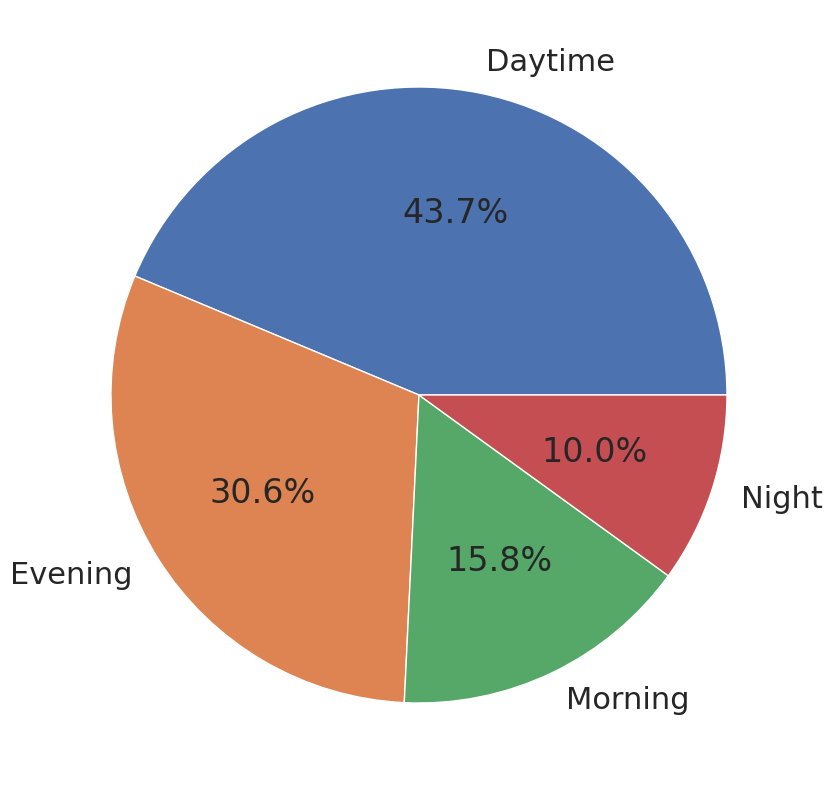

In [61]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.pie(pod_counts, labels=pod_counts.index, autopct='%1.1f%%');

In [77]:
# rs = np.random.RandomState(42)
# corr = trans_train.corr()
# corr.style.background_gradient(cmap='coolwarm')

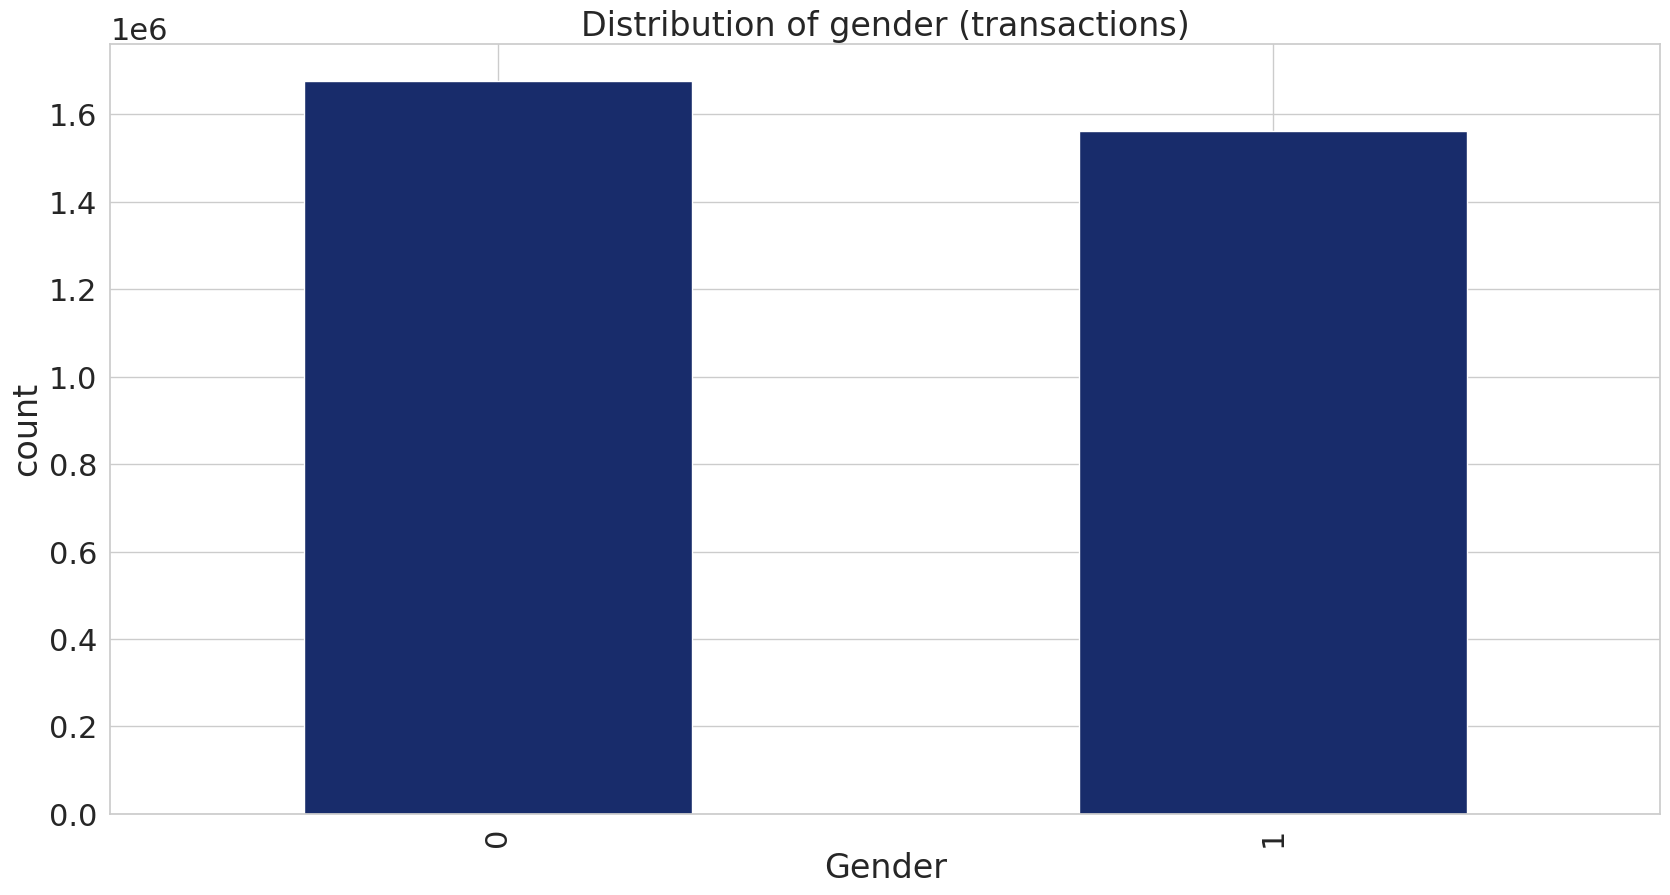

In [72]:
trans_train['gender'].value_counts(dropna = False).plot.bar(color='#182c6bff', figsize=(20, 10))

plt.title('Distribution of gender (transactions)')
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()

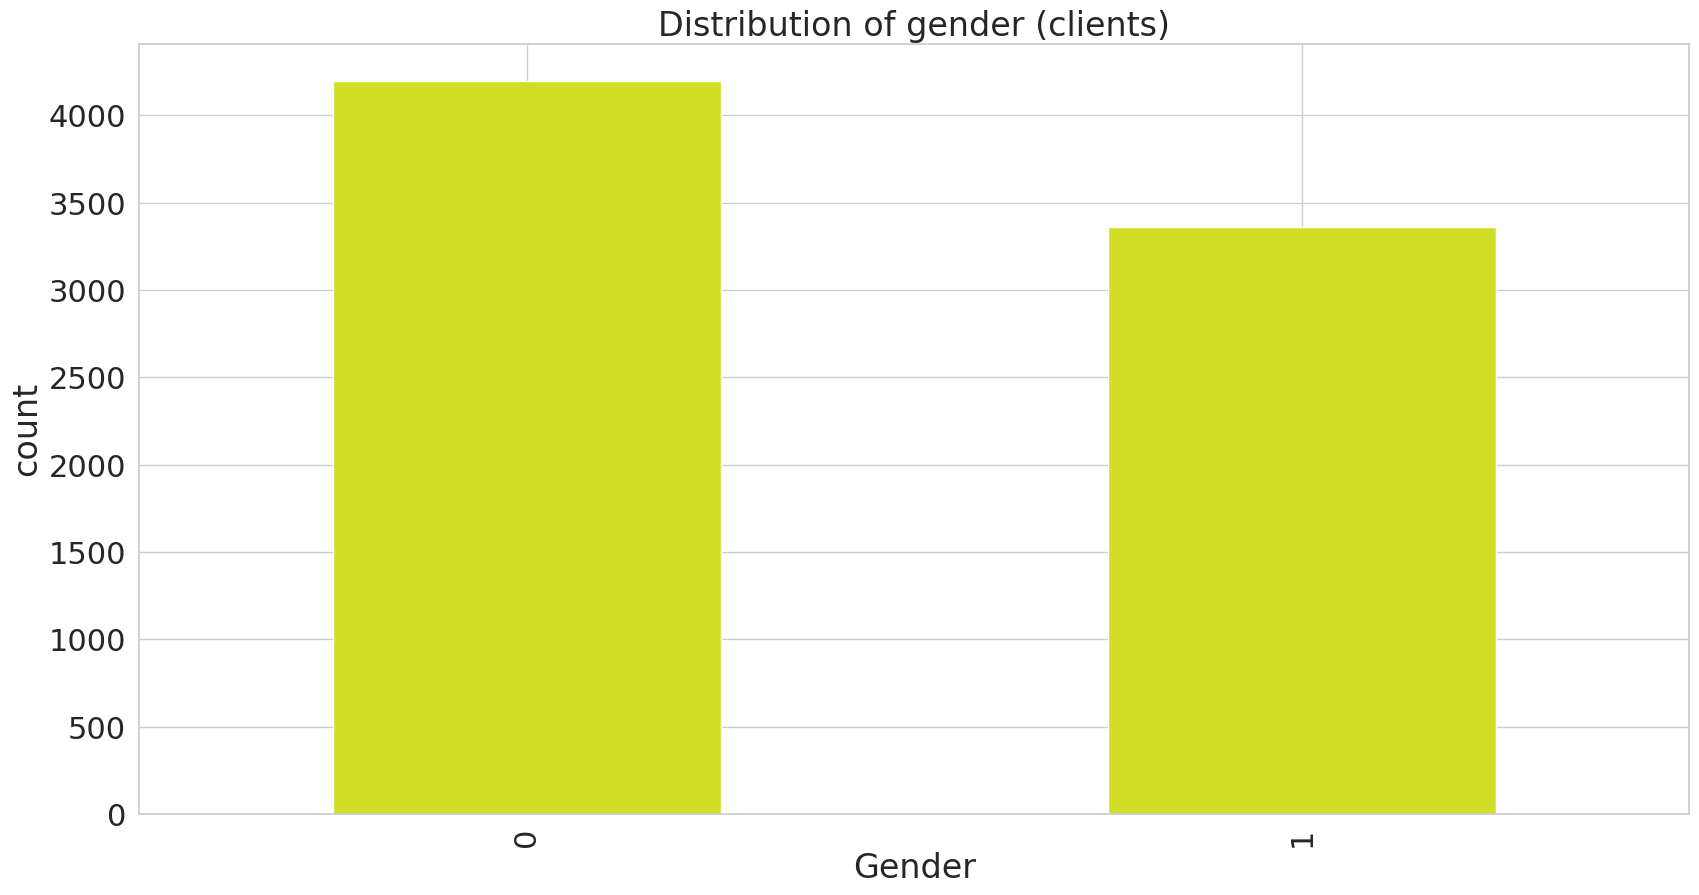

In [71]:
trans_train.groupby('client_id')['gender'].agg('first').value_counts().plot.bar(color='#d2de26ff', figsize=(20, 10))

plt.title('Distribution of gender (clients)')
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()